In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Load Data & Preprocessing

In [3]:
dirPath = '/content/drive/My Drive/Foreign/'
print(os.listdir(dirPath),'\n')

['Etrade(google).csv', 'Schwab(google).csv', 'Fidelity.csv', 'TD(google).csv', 'Schwab.csv', 'IBKR(google).csv', 'TD.csv', 'IBKR.csv', 'Firstrade(google).csv', 'Ally(google).csv', 'eToro(google).csv', 'Etrade.csv', 'Stash(google).csv', 'Firstrade.csv', 'Ally.csv', 'eToro.csv', 'Stash.csv', 'Robinhood.csv', 'Robinhood(google).csv', 'Fidelity(google).csv'] 



In [4]:
list_of_df=[]

for data in os.listdir(dirPath):
    print(data)
    df = pd.read_csv(dirPath+data)
    if 'google' in data:
        df = df.drop(['likecounts'], axis=1)
        df['Time'] = df['Time'].apply(lambda x: datetime.strptime(x, "%B %d, %Y").strftime('%Y/%m/%d'))
    else:
#         df['Content'] = df['Title']+df['Content']
        df = df.drop(['Title'], axis=1)
        df['Time'] = df['Time'].apply(lambda x: datetime.strptime(x.split('T')[0], "%Y-%m-%d").strftime('%Y/%m/%d'))

    df.loc[:,'product'] = data

    list_of_df.append(df)

Etrade(google).csv
Schwab(google).csv
Fidelity.csv
TD(google).csv
Schwab.csv
IBKR(google).csv
TD.csv
IBKR.csv
Firstrade(google).csv
Ally(google).csv
eToro(google).csv
Etrade.csv
Stash(google).csv
Firstrade.csv
Ally.csv
eToro.csv
Stash.csv
Robinhood.csv
Robinhood(google).csv
Fidelity(google).csv


In [5]:
raw_data = pd.concat(list_of_df, ignore_index=True)
raw_data = raw_data[~raw_data['Content'].isna()].reset_index(drop=True)

In [6]:
raw_data = raw_data.drop_duplicates().reset_index(drop=True)

In [7]:
raw_data['product'] = raw_data['product'].apply(lambda x:x.split('(')[0].split('.')[0])

In [8]:
raw_data.loc[raw_data['dev_content'].apply(lambda x:len(str(x)))<4, 'dev_content']=''

In [9]:
raw_data = raw_data[raw_data['Star']>3].reset_index(drop=True)

In [10]:
raw_data['Y_m'] = raw_data['Time'].apply(lambda x: x[:7])

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [12]:
# raw_data = raw_data[raw_data['Content_len']>5].reset_index(drop=True)

In [13]:
raw_data['Content'] = raw_data['Content'].apply(lambda x: x.lower())

## get Bert embedding

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
def tokenize(reviews):
    encoding = tokenizer.encode_plus(
      reviews,
      max_length=150,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=False,
      truncation=True,  
      return_tensors='pt',  # Return PyTorch tensors
    )
    return encoding['input_ids']

def get_mask(reviews):
    encoding = tokenizer.encode_plus(
      reviews,
      max_length=150,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,  
      return_tensors='pt',  # Return PyTorch tensors
    )
    return encoding['attention_mask']

In [ ]:
raw_data['tokenize'] = raw_data['Content'].apply(lambda x: tokenize(x)[0])
raw_data['mask'] = raw_data['Content'].apply(lambda x: get_mask(x)[0])

In [ ]:
train_list = np.array(raw_data.loc[:,['tokenize', 'mask']]).tolist()
train_loader = DataLoader(train_list, batch_size=64, num_workers=0)

In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                  output_hidden_states = True, # Whether the model returns all hidden-states.
                  ).to(device)

In [ ]:
embedding = []
# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()
with torch.no_grad():
    for i,data in enumerate(train_loader, 0):
        print((i+1)*64/len(raw_data))
        token, mask = data
        token = token.to(device)
        mask = mask.to(device)

        out = model(input_ids=token,
                      attention_mask=mask)

        # Evaluating the model will return a different number of objects based on 
        # how it's  configured in the `from_pretrained` call earlier. In this case, 
        # becase we set `output_hidden_states = True`, the third item will be the 
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel


        hidden_states = out[2] #hidden_state(layer, batch, token, vector)

        embedding.extend(torch.sum(hidden_states[10], axis=1)/150)

0.0008365466309391543
0.0016730932618783086
0.002509639892817463
0.003346186523756617
0.004182733154695772
0.005019279785634926
0.0058558264165740805
0.006692373047513234
0.007528919678452389
0.008365466309391544
0.009202012940330698
0.010038559571269852
0.010875106202209005
0.011711652833148161
0.012548199464087315
0.013384746095026469
0.014221292725965623
0.015057839356904778
0.015894385987843932
0.016730932618783088
0.01756747924972224
0.018404025880661395
0.019240572511600548
0.020077119142539703
0.02091366577347886
0.02175021240441801
0.022586759035357167
0.023423305666296322
0.024259852297235474
0.02509639892817463
0.025932945559113782
0.026769492190052938
0.027606038820992093
0.028442585451931245
0.0292791320828704
0.030115678713809556
0.03095222534474871
0.031788771975687864
0.03262531860662702
0.033461865237566175
0.034298411868505324
0.03513495849944448
0.035971505130383635
0.03680805176132279
0.037644598392261946
0.038481145023201095
0.03931769165414025
0.040154238285079406


In [ ]:
raw_data['embedding'] = embedding

In [ ]:
raw_data['embedding'] = raw_data['embedding'].apply(lambda x: x.data.cpu().numpy())

In [ ]:
embedding = [x.data.cpu().numpy() for x in embedding]

In [ ]:
embedding_df = pd.DataFrame(embedding)

In [ ]:
# path = F"/content/drive/My Drive/embedding.csv" 

In [ ]:
# embedding_df.to_csv(path)

#### Load Bert Embeddiing data

In [14]:
embedding_df = pd.read_csv('/content/drive/My Drive/embedding.csv')
embedding_df = embedding_df.drop(['Unnamed: 0'], axis=1)

### cluster by Bert Embedding

In [15]:
embedding_df = embedding_df[raw_data['product'].isin(['Fidelity','TD','Stash','Robinhood'])].reset_index(drop=True)

In [16]:
raw_data = raw_data[raw_data['product'].isin(['Fidelity','TD','Stash','Robinhood'])].reset_index(drop=True)

In [18]:
from sklearn.cluster import KMeans

In [ ]:
# SSE with Kmeans, find the besk K

sse = []
for i in range(3,16):
    cluster = KMeans(n_clusters=i).fit(embedding_df)
    sse.append(cluster.inertia_)

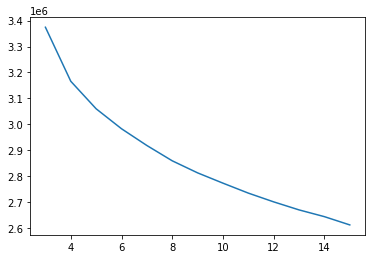

In [ ]:
plt.plot(range(3,16),sse)

In [19]:
cluster_list = KMeans(n_clusters=15).fit_predict(embedding_df)

In [ ]:
# LDA_data = raw_data.drop(['tokenize','mask'], axis=1)

In [20]:
raw_data['group'] = cluster_list

In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [22]:
raw_data['Content'] = raw_data['Content'].apply(lambda x: nltk.word_tokenize(x))

## 區分詞性

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
sw=stopwords.words('english')
en_sw = pd.read_csv('/content/drive/My Drive/en_sw.txt')
sw.extend(list(en_sw['en_sw']))

In [25]:
# 還原文字，並將他們依詞性分類

def get_wordnet_pos (treebank_tag):
    if treebank_tag.startswith( 'J' ):
        return wordnet.ADJ
    elif treebank_tag.startswith( 'V' ):
        return wordnet.VERB
    elif treebank_tag.startswith( 'N' ):
        return wordnet.NOUN
    elif treebank_tag .startswith( 'R' ):
        return wordnet.ADV
    else :
        return  None

    
def lemmatize (df):
    res = []
    verb = []
    adj = []
    noun = []
    lemmatizer = WordNetLemmatizer()
    for word, pos in pos_tag(df['Content']):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        if word not in sw and word.isalpha():
            res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

            if get_wordnet_pos(pos) == wordnet.VERB:
                verb.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

            if get_wordnet_pos(pos) == wordnet.ADJ:
                adj.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

            if get_wordnet_pos(pos) == wordnet.NOUN:
                noun.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
        
    df['Content'] = res
    df['verb'] = verb    
    df['adj'] = adj
    df['noun'] = noun
    
    return df

In [26]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [27]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [28]:
LDA_data = raw_data.apply(lemmatize, axis=1)

## Calculate N-gram

In [29]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

ngram
- (count(a followed by b) - min_count) * N/(count(a) * count(b)) > threshold <br>
 https://tinyurl.com/y5yz68wa <br>
 https://tinyurl.com/y4xrt4a6

In [30]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(LDA_data['Content'], min_count=10, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[LDA_data['Content']], threshold=5)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[LDA_data['Content'][0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['investigate', 'year', 'novice', 'stock_market', 'know', 'want', 'company', 'nurse', 'question', 'charge', 'force', 'opinion', 'buy', 'hear', 'buy_sell_high', 'key', 'money', 'loose_money', 'market', 'hand', 'kind', 'call', 'professional', 'broker', 'analyst', 'screamer', 'investment_firm', 'ability', 'buying_selling', 'electronically', 'extremely', 'cost', 'perfect', 'fit', 'ability', 'reach', 'question', 'perfect', 'fit', 'enjoy', 'trading', 'make_money', 'stock_market', 'female', 'extremely', 'satisfying', 'rewarding', 'female', 'consumer', 'household', 'lady', 'woman', 'girl', 'invest', 'stock_market', 'fit', 'millionaire', 'jump', 'market', 'small', 'trader', 'today', 'happy', 'shopping']


In [31]:
LDA_data['Content'] = LDA_data['Content'].apply(lambda x: trigram_mod[bigram_mod[x]])

In [32]:
LDA_data['adj_n'] = (LDA_data['adj']+LDA_data['noun'])
LDA_data['adj_v'] = (LDA_data['adj']+LDA_data['verb'])
LDA_data['n_v'] = (LDA_data['noun']+LDA_data['verb'])

### 將n gram的字取出加入所有詞性字詞中

In [33]:
LDA_data['n_gram'] = LDA_data['Content'].apply(lambda x:[word for word in x if '_' in word])

In [34]:
for col in LDA_data.columns[8:14]:
    LDA_data[col] = LDA_data[col]+LDA_data['n_gram']

# Feature Extraction

## TF-IDF

In [ ]:
col = ['Content','verb','adj','noun','adj_n','adj_v','n_v']

In [ ]:
for g in LDA_data['group'].unique():  
    for t in col:
        sub_df = LDA_data[LDA_data['group']==g]

        # 將corpus轉成詞頻矩陣
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(sub_df[t].apply(lambda x: " ".join(x)))
        # 可以得到詞頻矩陣中所有的字
        word = vectorizer.get_feature_names()

        transformer = TfidfTransformer()
        # 將詞頻矩陣轉為tf_idf
        tfidf = transformer.fit_transform(X)

        df = pd.DataFrame({'word':vectorizer.get_feature_names(), 'tfidf':tfidf.toarray().sum(axis=0).tolist()}).sort_values(by='tfidf',ascending=False)

        print(t)
        print(df['word'].values[:10])
        print()
    print('-'*100)

Content
['invest' 'easy' 'great' 'stock' 'love' 'trade' 'money' 'start' 'trading'
 'time']

verb
['invest' 'love' 'start' 'learn' 'buy' 'recommend' 'work' 'trade'
 'stock_market' 'understand']

adj
['easy' 'great' 'good' 'free' 'stock_market' 'simple' 'nice'
 'user_friendly' 'small' 'highly_recommend']

noun
['stock' 'money' 'time' 'account' 'market' 'trading' 'investment' 'year'
 'trade' 'day']

adj_n
['stock' 'easy' 'great' 'money' 'account' 'time' 'market' 'trading' 'good'
 'investment']

adj_v
['easy' 'great' 'invest' 'love' 'good' 'start' 'learn' 'recommend' 'buy'
 'free']

n_v
['stock' 'invest' 'love' 'money' 'trade' 'account' 'start' 'time'
 'trading' 'market']

----------------------------------------------------------------------------------------------------
Content
['easy' 'great' 'invest' 'good' 'user_friendly' 'stock' 'love' 'simple'
 'trading' 'easy_navigate']

verb
['invest' 'user_friendly' 'love' 'learn' 'navigate' 'start'
 'easy_navigate' 'understand' 'recommend' 'work

## Topic Model

### merge reviews by cluster


In [35]:
# delete the data there's only one token
LDA_data['tokenized_len'] = LDA_data['Content'].apply(lambda x: len(x))
LDA_data = LDA_data[LDA_data['tokenized_len']!=1].reset_index(drop=True)

In [36]:
LDA_data = LDA_data[~(LDA_data['n_v'].apply(lambda x: str(x))=='[]')].reset_index(drop=True)

In [37]:
LDA_data = LDA_data.sort_values(by=['group'], ascending=True)

In [38]:
LDA_data = LDA_data.reset_index(drop=True)

In [39]:
group_idx = LDA_data.groupby('group').size().values

In [40]:
group_idx_sum = [0]
count = 0
for i in range(len(group_idx)):
    count += group_idx[i]
    group_idx_sum.append(count)

In [41]:
def group(original_list,n=113):

    return [original_list[x:x+n] for x in range(0,len(original_list),n)]

In [64]:
doc_word = []
for idx in range(len(LDA_data['group'].unique())):

    documents = group(LDA_data[group_idx_sum[idx]:group_idx_sum[idx+1]]['n_v'],n=group_idx.min())

    for i in range(len(documents)):

        doc_word.append([item for sublist in documents[i] for item in sublist])

In [43]:
# Create Dictionary
id2word = corpora.Dictionary(doc_word)
id2word.filter_extremes(no_below=1, no_above=0.8)
# Term Document Frequency
# converts the word to its integer word id and returns the result as a sparse vector.
corpus = [id2word.doc2bow(text) for text in doc_word]

In [ ]:
# Build LDA model
eval=[]
for i in range(3,21):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                        id2word=id2word,
                        num_topics=i, 
                        alpha=[0.01]*i,
                        random_state=100,
                        # update_every=1, #update every 1 batch
                        eta=[0.01]*len(id2word.keys()),
                        passes=4)
  
    eval.append(CoherenceModel(model=lda_model, texts=doc_word, dictionary=id2word, coherence='c_v').get_coherence())

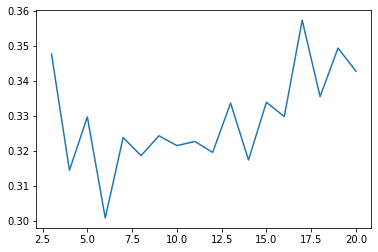

In [ ]:
plt.plot(range(3,21) , eval)

In [65]:
# Create Dictionary
id2word = corpora.Dictionary(doc_word)
id2word.filter_extremes(no_below=1, no_above=0.8)
# Term Document Frequency
# converts the word to its integer word id and returns the result as a sparse vector.
corpus = [id2word.doc2bow(text) for text in doc_word]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                      id2word=id2word,
                      num_topics=3, 
                      alpha=[0.01]*3,
                      random_state=100,
                      # update_every=1, #update every 1 batch
                      eta=[0.01]*len(id2word.keys()),
                      passes=3)

x=lda_model.show_topics(num_topics=3, num_words=30, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))
print()

#Below Code Prints Only Words 
for topic,words in topics_words:
    print(" ".join(words))

串流輸出內容已截斷至最後 5000 行。
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator

0::['trade', 'market', 'account', 'buy', 'recommend', 'option', 'platform', 'day', 'lot', 'beginner', 'feature', 'year', 'sell', 'investor', 'understand', 'service', 'tool', 'company', 'user_friendly', 'stock_market', 'fee', 'navigate', 'update', 'share', 'customer', 'portfolio', 'people', 'experience', 'interface', 'save']
1::['account', 'save', 'market', 'day', 'trade', 'option', 'buy', 'investor', 'share', 'company', 'month', 'lot', 'bank', 'update', 'feature', 'year', 'understand', 'service', 'platform', 'add', 'portfolio', 'fund', 'beginner', 'fun', 'experience', 'enjoy', 'recommend', 'issue', 'grow', 'apps']
2::['account', 'trade', 'buy', 'year', 'market', 'day', 'option', 'lot', 'save', 'bank', 'fee', 'platform', 'company', 'beginner', 'experience', 'month', 'recommend', 'stock_market', 'feature', 'service', 'share', 'people', 'portfolio', 'help', 'tool', 'enjoy', 'update', 'investor', 'fund', 'grow']

trade market account buy recommend option platform day lot beginner feature y

In [46]:
pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 552kB 18.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=129438177a8d174f43d7692261c22a93ce636a3070a92f35cf1a087a65965508
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=6d4ce74625aba3ef33eb304375cdf67d7af0b637096e01983b165c3054380ac9
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [67]:
#@title 預設標題文字
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)
pyLDAvis.display(vis)

In [ ]:
pyLDAvis.save_html(p, 'lda.html')

In [59]:
lda_model.get_document_topics(corpus[0])

[(0, 0.87374794), (2, 0.12616436)]